In [67]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [68]:

def custom_activation(x):
    return tf.sin(x)

In [69]:
NN = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input((2,)),
        tf.keras.layers.Dense(units=32, activation=custom_activation),
        tf.keras.layers.Dense(units=32, activation=custom_activation),
        tf.keras.layers.Dense(units=1),
    ]
)

NN.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,185 (4.63 KB)

 Trainable params: 1,185 (4.63 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
optm = tf.keras.optimizers.Adam(learning_rate=0.001)
NN.compile(optimizer="Adam", loss="mean_squared_error")

In [71]:
def real_u(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

In [72]:
def ode_system(coord, net, boarder):
    boarder = tf.constant(boarder, dtype=tf.float32)
    coord = tf.constant(coord, dtype=tf.float32)
    coord_0 = tf.zeros((1, 2))
    # y = coord[..., 1]
    # x = tf.constant(x, dtype=tf.float32)
    # y = tf.convert_to_tensor(y)
    with tf.GradientTape(
        watch_accessed_variables=False, persistent=True
    ) as tape_first:
        tape_first.watch(coord)
        u = net(coord)
        u_coord = tape_first.gradient(u, coord)
        du_dx = u_coord[..., 0]
        du_dy = u_coord[..., 1]
        du_dxdx = tape_first.gradient(u_coord, coord)[..., 0]
        du_dydy = tape_first.gradient(u_coord, coord)[..., 1]
    del tape_first
    # u_coord = tape_first.gradient(u, coord)
    # u_x = u_coord[..., 0]
    # u_y = u_coord[..., 1]
    x = coord[..., 0]
    y = coord[..., 1]
    tf_pi = tf.constant(np.pi)
    ode_loss = du_dxdx + du_dydy - (-2 * tf_pi * tf_pi * tf.sin(tf_pi * y) * tf.sin(tf_pi * x))
    IC_loss = net(boarder) - tf.zeros((len(boarder), 1))
    square_loss = tf.square(ode_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

### Params

In [73]:
grid_size = (50, 50)
x_limits = (0, np.pi)
y_limits = (0, np.pi)
boarder_grid_size = (10, 10)

In [74]:
x = np.linspace(x_limits[0], x_limits[1], boarder_grid_size[0])
y = np.linspace(y_limits[0], y_limits[1], boarder_grid_size[1])
# y = np.random.uniform(1, 10, 10)
x, y = np.meshgrid(x, y)
train_coord = np.column_stack((x.flatten(), y.flatten()))

boarder = train_coord.reshape(boarder_grid_size[0], boarder_grid_size[1], 2)
boarder_01 = np.append(boarder[0], boarder[0][..., [1, 0]])
boarder_02 = np.append(boarder[boarder_grid_size[0] - 1], boarder[boarder_grid_size[0] - 1][..., [1, 0]])
boarder = np.append(boarder_01, boarder_02).reshape(boarder_grid_size[0] * 4, 2)

x = np.linspace(x_limits[0], x_limits[1], grid_size[0])
y = np.linspace(y_limits[0], y_limits[1], grid_size[1])

x, y = np.meshgrid(x, y)
train_coord = np.column_stack((x.flatten(), y.flatten()))
# train_coord = x
train_loss_record = []

88.35027
2.6307857
0.24356617
0.13499415
0.094647735


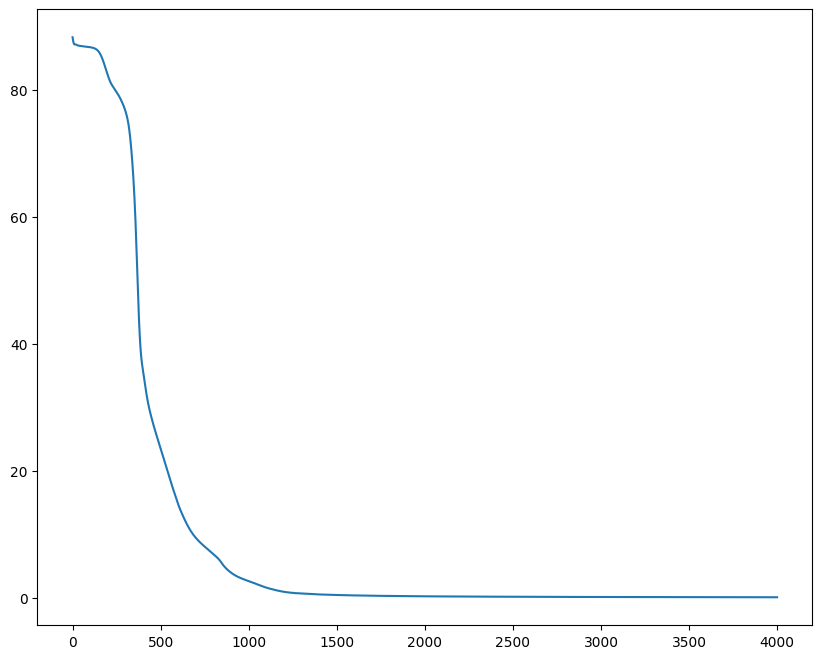

In [75]:
for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_coord, NN, boarder)
        train_loss_record.append(train_loss)

    grad_w = tape.gradient(train_loss, NN.trainable_variables)
    optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())
        
        if train_loss < 0.1:
            break

plt.figure(figsize=(10, 8))
plt.plot(train_loss_record)
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


[(0.0, 3.141592653589793),
 (0.0, 3.141592653589793),
 Text(0.5, 0, 'X'),
 Text(0.5, 0.5, 'Y'),
 Text(0.5, 0, 'Z')]

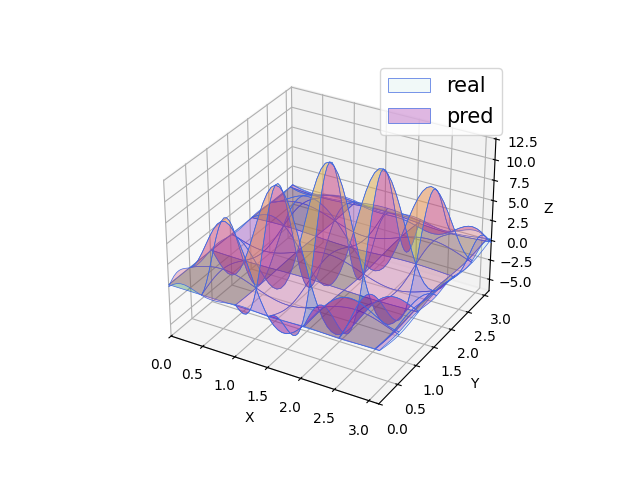

In [78]:
%matplotlib widget
test_x = np.linspace(x_limits[0], x_limits[1], grid_size[0])
test_y = np.linspace(x_limits[0], x_limits[1], grid_size[1])
test_x, test_y = np.meshgrid(test_x, test_y)

train_u = real_u(x, y)
true_u = real_u(test_x, test_y)
test_coord = np.column_stack((test_x.flatten(), test_y.flatten()))
pred_coord = list()
for _x in x[0]:
    for _y in x[0]:
        pred_coord.append([_x, _y])
pred_u = NN.predict(np.array(pred_coord)).ravel().reshape(grid_size[0], grid_size[1])
# plt.figure(figsize=(10, 8))
# plt.plot(x, train_u, "ok", label="Train")
# plt.plot_s(test_x, true_u, "-k", label="True")
# plt.plot(test_t, pred_u, "--r", label="Prediction")
# plt.legend(fontsize=15)
# plt.xlabel("t", fontsize=15)
# plt.ylabel("u", fontsize=15)
# plt.show()
ax = plt.figure().add_subplot(projection="3d")
ax.plot_surface(
    test_x,
    test_y,
    true_u,
    edgecolor="royalblue",
    lw=0.5,
    rstride=8,
    cstride=8,
    alpha=0.3,
    cmap="BuGn",
    label="real"
)
ax.plot_surface(
    x,
    y,
    pred_u,
    edgecolor="royalblue",
    lw=0.5,
    rstride=8,
    cstride=8,
    alpha=0.3,
    cmap="plasma",
    label="pred",
)
# ax.scatter(x, y, train_u, s=0.5, label="train")
ax.legend(fontsize=15)
ax.set(xlim=x_limits, ylim=y_limits, xlabel="X", ylabel="Y", zlabel="Z")

# Accuracy calculation

In [77]:
# Calculate the number of correct predictions
correct_predictions = np.sum(np.isclose(pred_u, true_u, rtol=1))

# Calculate the total number of predictions
total_predictions = np.prod(grid_size)

# Calculate the accuracy
accuracy = correct_predictions / total_predictions

print("Accuracy:", accuracy)

Accuracy: 0.144
